# Simulations
This notebook reproduces the simulation results from Section 4 of "Hierarchical Causal Models", E. N. Weinstein and D. M. Blei, 2023.

To run the notebook, make sure you are using Python 3 and have the below packages installed in your environment. The code was tested with

-- python=3.12.0

-- numpy=1.26.2

-- matplotlib=3.8.0

-- scipy=1.11.4

-- pandas=2.1.4



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, bernoulli, norm
from scipy.special import logit, expit
from scipy import integrate
import pandas as pd

from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression

# Whether and where to save figures.
save_figs = False
save_folder = 'saved_figs/'

# CONFOUNDER model

#### Model & Estimators

In [2]:
class ConfounderModel:
    def __init__(self, U_omega, A_alphas_U, A_betas_U, YA_alphas_Ua, YA_betas_Ua):
        """Initialization: true data generating parameters."""
        # Parameter for p(u)
        self.U_omega = U_omega
        # Parameters for p(q^a|u)
        self.A_alphas_U = A_alphas_U
        self.A_betas_U = A_betas_U
        # Parameters for p(q^{y|a} | u)
        self.YA_alphas_Ua = YA_alphas_Ua
        self.YA_betas_Ua = YA_betas_Ua
    
    def sample(self, M, N):
        """Generate data."""
        # Sample U.
        U = bernoulli(self.U_omega).rvs(size=N)
        # Sample q^a.
        A_mu = beta(self.A_alphas_U[U], self.A_betas_U[U]).rvs()
        # Sample q^{y|a}
        YA_mu = beta(self.YA_alphas_Ua[U], self.YA_betas_Ua[U]).rvs()
        # Sample A.
        A = bernoulli(A_mu[:, None] * np.ones(M)).rvs()
        # Sample Y.
        Y = bernoulli(YA_mu[:, 0, None] * (1 - A) + YA_mu[:, 1, None] * A).rvs()
        
        return A, Y
    
    def true_effect(self, a):
        """Compute the true effect, E_p[E_Q[Y]|do(q^a = delta_a)]."""
        return ((1 - self.U_omega) * beta(self.YA_alphas_Ua[0, a], self.YA_betas_Ua[0, a]).mean() +
                self.U_omega * beta(self.YA_alphas_Ua[1, a], self.YA_betas_Ua[1, a]).mean())
    
    def estimate_effect(self, A, Y, a):
        """Estimate the effect using the HCM identification formula."""
        match = A == a
        # Use one pseudocount (posterior mean for Beta(1, 1) prior)
        return np.mean((np.sum(Y * match, axis=1) + 1) / (np.sum(match, axis=1) + 2))
    
    def regression_estimate(self, A, Y, a):
        """Estimate the effect using regression on the within-unit averages."""
        Amn = np.mean(A, axis=1, keepdims=True)
        Ymn = np.mean(Y, axis=1)
        reg = LinearRegression().fit(Amn, Ymn)
        return reg.predict(np.array([[a]]))[0]

#### Run simulations

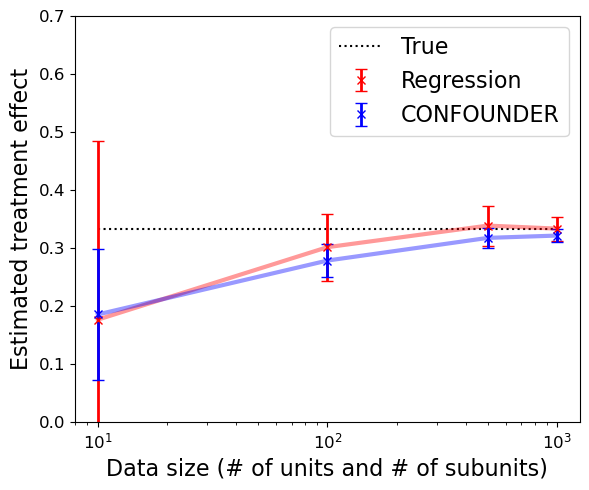

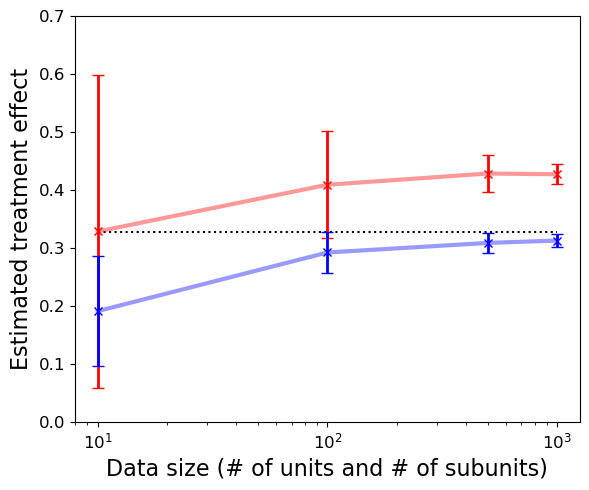

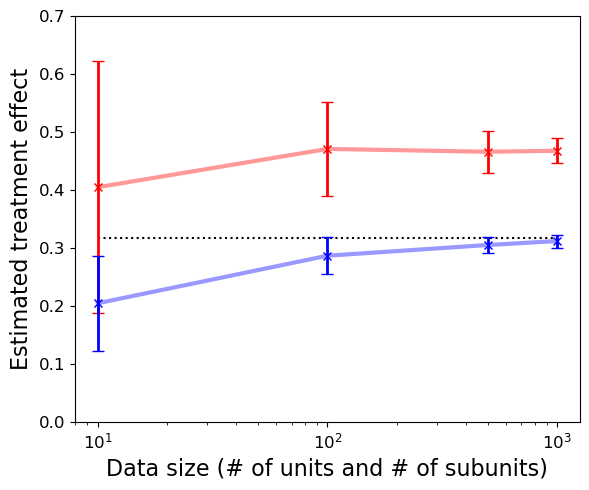

In [3]:
# Data generating parameters
U_omegas = [0., 0.2, 0.5]
A_alphas_U = np.array([0.5, 4])
A_betas_U = np.array([1., 1.])
YA_alphas_Ua = np.array([[0.5, 2], [1, 4]])
YA_betas_Ua = np.ones((2, 2))
nsamps = [10, 100, 500, 1000]
reps = 20
ylim = [0, 0.7]

# Iterate over confounding levels.
for ui, U_omega in enumerate(U_omegas):

    # Initialize the model.
    model = ConfounderModel(U_omega, A_alphas_U, A_betas_U, YA_alphas_Ua, YA_betas_Ua)

    # Store estimates
    estimated_ate = np.zeros((reps, len(nsamps)))
    regress_ate = np.zeros((reps, len(nsamps)))
    
    # Random seed.
    np.random.seed(0)
    
    # Iterate over repetitions
    for i in range(reps):
        # Draw samples for full dataset.
        A, Y = model.sample(max(nsamps), max(nsamps))

        # Iterate over data set sizes.
        for j, nsamp in enumerate(nsamps):
            # Collect subset of full dataset. 
            A_sub, Y_sub = A[:nsamp, :nsamp], Y[:nsamp, :nsamp]
            # Compute confounder model-based estimate.
            estimated_ate[i, j] = (model.estimate_effect(A_sub, Y_sub, 1) - 
                                   model.estimate_effect(A_sub, Y_sub, 0))
            # Compute regression estimate.
            regress_ate[i, j] = (model.regression_estimate(A_sub, Y_sub, 1) - 
                               model.regression_estimate(A_sub, Y_sub, 0))
    # Compute true effect.
    true_ate = model.true_effect(1) - model.true_effect(0)

    # Plot results.
    plt.figure(figsize=(6, 5))
    plt.plot(nsamps, np.ones_like(nsamps) * true_ate, 'k:', label='True')
    plt.errorbar(nsamps, np.mean(regress_ate, axis=0), yerr=np.std(regress_ate, axis=0), color='red', 
                 linewidth=0, label='Regression', marker='x', capsize=4, elinewidth=2)
    plt.errorbar(nsamps, np.mean(estimated_ate, axis=0), yerr=np.std(estimated_ate, axis=0), color='blue', 
                 linewidth=0, label=r'CONFOUNDER', marker='x', capsize=4, elinewidth=2)
    if ui == 0:
        plt.legend(fontsize=16)
    plt.plot(nsamps, np.mean(regress_ate, axis=0), linewidth=3, alpha=0.4, color='red')
    plt.plot(nsamps, np.mean(estimated_ate, axis=0), linewidth=3, alpha=0.4, color='blue')
    plt.xlabel(r'Data size (# of units and # of subunits)', fontsize=16)
    plt.ylabel('Estimated treatment effect', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(ylim)
    plt.xscale('log')
    plt.tight_layout()

    if save_figs:
        plt.savefig(save_folder + 'unobserved_confound_strength_{}.pdf'.format(U_omega))

# CONFOUNDER & INTERFERENCE model

#### Model & Estimators

In [4]:
def normal_expit(b, c, x):
    # Function for integrating expit against Gaussian base distribution.
    return expit(b + c * x) * norm.pdf(x)
    
class InterferenceModel:
    def __init__(self, A_beta, A_scale, Z_tau, Z_mn, YA_delta, YA_rho, YA_beta, YA_sigma):
        """Initialization: true data generating parameters."""
        # Parameters for p(q^a | u)
        self.A_beta = A_beta
        self.A_scale = A_scale
        # Parameters for p(z | q^a)
        self.Z_tau = Z_tau
        self.Z_mn = Z_mn
        # Parameters for p(q^{y|a} | z, u)
        self.YA_delta = YA_delta
        self.YA_rho = YA_rho
        self.YA_beta = YA_beta
        self.YA_sigma = YA_sigma
    
    def sample(self, M, N):
        """Generate data."""
        # Sample U.
        U = norm.rvs(size=N)
        # Sample q^a.
        logit_A_rho = norm(self.A_beta * U, self.A_scale).rvs()
        A_rho = expit(logit_A_rho)
        # Sample A.
        A = bernoulli(A_rho[:, None] * np.ones(M)).rvs()
        # Sample Z.
        # ** delete: Z_mn = self.sigma(self.logit_est(np.mean(A, axis=1)))
        Z_mn = expit(self.Z_tau*(logit(np.mean(A, axis=1)) - self.Z_mn))
        Z = bernoulli(Z_mn).rvs()
        # Sample q^{y|a}
        logit_YA_rho = norm(np.array([0., self.YA_delta])[None, :] +
                            self.YA_rho * (2 * Z - 1)[:, None] +
                            self.YA_beta * U[:, None], 
                            self.YA_sigma).rvs()
        YA_rho = expit(logit_YA_rho)
        # Sample Y.
        Y = bernoulli(YA_rho[:, 0, None] * (1 - A) + YA_rho[:, 1, None] * A).rvs()
        
        return A, Z, Y
    
    def true_effect(self, qA):
        """Compute the true effect, E_p[E_Q[Y]|do(q^a = qA)]."""
        # Total effect.
        effect = 0
        # Iterate over a values.
        for a in range(2):
            if a == 1:
                a_term = qA
            else:
                a_term = 1 - qA
            # Iterate over z values.
            for z in range(2):
                pz = expit(self.Z_tau*(logit(qA) - self.Z_mn))
                if z == 1:
                    z_term = pz
                else:
                    z_term = 1 - pz

                # Compute the expectation with numerical integration.
                integ = integrate.quad(lambda u: normal_expit(self.YA_delta * a + self.YA_rho * (2 * z - 1), 
                                                              np.sqrt(self.YA_beta**2 + self.YA_sigma**2), u), -5, 5)

                # Add term to total effect.
                effect += a_term * z_term * integ[0]
            
        return effect
    
    def estimate_Q(self, A, Y):
        """Estimate the Q variables for each unit.""" 
        N, M = A.shape
        # Estimate q^a. We use pseudocounts for regularization, so our estimate is equivalent to
        # the posterior mean of a Beta-Bernoulli model with a Beta(1, 1) prior.
        A_mn_est = (np.sum(A, axis=1) + 1)/(M+2)
        # Estimate q^{y|a} 
        YA_mn_est = np.stack([(np.sum(Y * (A == 0), axis=1) + 1) / (np.sum(A == 0, axis=1) + 2),
                               (np.sum(Y * (A == 1), axis=1) + 1) / (np.sum(A == 1, axis=1) + 2)],
                              axis=1)
        return A_mn_est, YA_mn_est
    
    def estimate_effect(self, A, Z, Y, qAs, n_samps=100):
        """Estimate the effect using the HCM identification formula."""
        N, M = A.shape
        # Estimate subunit distribution.
        A_mn_est, YA_mn_est = self.estimate_Q(A, Y)
        
        # Learn regression from Q^A to Z
        lreg_z = LogisticRegression() 
        X1 = logit(A_mn_est)[:, None]
        lreg_z.fit(X1, Z)
        
        # Estimate Z probability under interventions.
        qA_transf = logit(qAs)[:, None]
        PZ_qAs = lreg_z.predict_proba(qA_transf)[:, 1]
        
        # Learn regression from Q^A and Z to Q^Y|A
        lreg_qya = [[None, None], [None, None]]
        lreg_qya_std = [[None, None], [None, None]]
        for a in range(2):
            for z in range(2):
                lreg_qya[a][z] = LinearRegression()
                logit_YA_mn_est = logit(YA_mn_est[Z == z][:, a])
                # Fit linear model.
                lreg_qya[a][z].fit(X1[Z == z], logit_YA_mn_est)
                # Estimate noise standard deviation from residual.
                lreg_qya_std[a][z] = np.sqrt(np.mean((lreg_qya[a][z].predict(X1[Z == z]) 
                                                      - logit_YA_mn_est)**2))
        
        # Compute effect estimate.
        effects = np.zeros(2)
        # Iterate over interventions.
        for i in range(2):
            eEl_QYA = np.zeros(2)
            # Iterate over z values.
            for z in range(2):
                # Compute z probability.
                if z == 0:
                    PZz_qA = 1 - PZ_qAs[i]
                elif z == 1:
                    PZz_qA = PZ_qAs[i]
                # Iterate over a values.
                for a in range(2):
                    # Sample from distribution over q^{y|a}.
                    qya_mu_logit = lreg_qya[a][z].predict(X1)
                    qya_mu_samples = expit(norm(qya_mu_logit[:, None] * np.ones((1, n_samps)), 
                                                lreg_qya_std[a][z]).rvs())
                    # Compute expected value of q^{y|a}.
                    E_qya = np.mean(qya_mu_samples, axis=1)
                    eEl_QYA[a] += np.mean(E_qya)*PZz_qA

            # Compute expected value of Y.
            effects[i] = eEl_QYA[1] * qAs[i] + eEl_QYA[0] * (1 - qAs[i])

        # Compute difference in treatment effects.
        return effects[1] - effects[0]

    def no_interfere_estimate(self, A, Z, Y, qAs):
        """Estimate the effect based on the CONFOUNDER graph (i.e. ignoring interference).""" 
        effects = np.zeros(2)
        for a in range(2):
            match = A == a
            effects[a] = np.mean((np.sum(Y * match, axis=1) + 1) / (np.sum(match, axis=1) + 2))
        return effects[1] * (qAs[1] - qAs[0]) + effects[0] * (qAs[0] - qAs[1])

    def regress_estimate(self, A, Y, qAs):
        """Estimate the effect using linear regression on aggregated data."""
        Amn = np.mean(A, axis=1, keepdims=True)
        Ymn = np.mean(Y, axis=1)
        reg = LinearRegression().fit(Amn, Ymn)
        return reg.predict(np.array([[qAs[1]]]))[0] - reg.predict(np.array([[qAs[0]]]))[0]

#### Run simulations

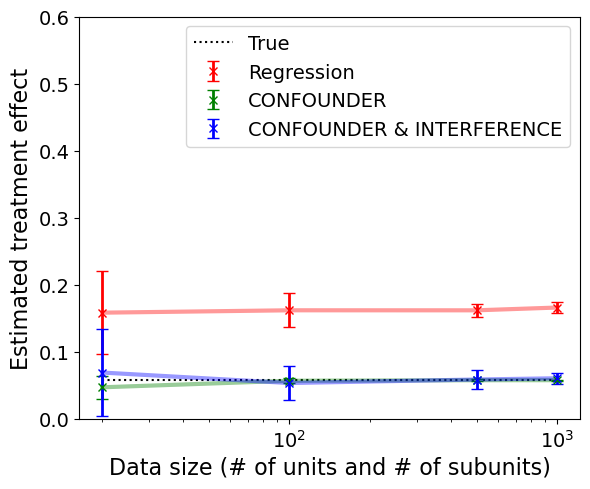

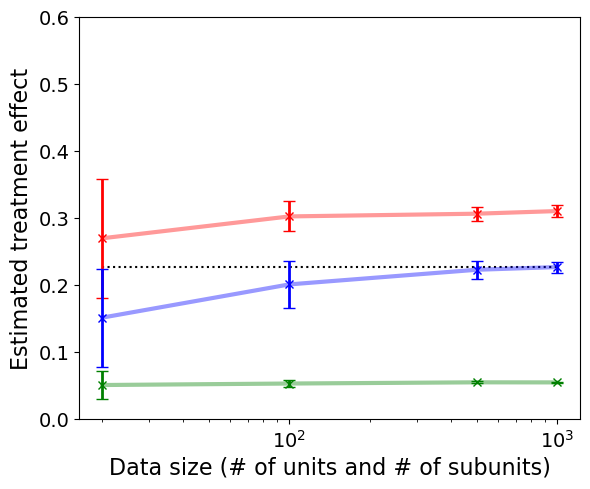

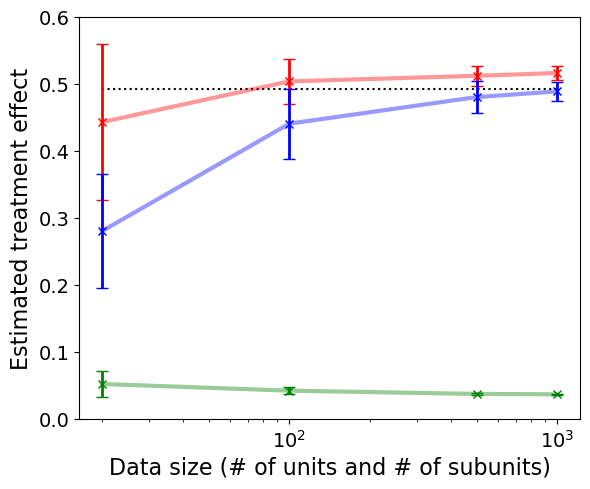

In [5]:
A_beta = 0.5
A_scale = 1.
Z_tau = 2. 
Z_mn = 0.4
YA_delta = 0.5
YA_rhos = [0, 0.5, 1.5]
YA_beta = 0.5
YA_sigma = 0.1
qAs = np.array([0.25, 0.75])
nsamps = [20, 100, 500, 1000]
reps = 20
ylim = [0., 0.6]

for rhoi, YA_rho in enumerate(YA_rhos):

    model = InterferenceModel(A_beta, A_scale, Z_tau, Z_mn, YA_delta, YA_rho, YA_beta, YA_sigma)
    
    estimated_effect = np.zeros((reps, len(nsamps)))
    no_interfere_effect = np.zeros((reps, len(nsamps)))
    regress_effect = np.zeros((reps, len(nsamps)))
    np.random.seed(1)
    for i in range(reps):
        A, Z, Y = model.sample(max(nsamps), max(nsamps))
        for j, nsamp in enumerate(nsamps):
            Z_sub, A_sub, Y_sub = Z[:nsamp], A[:nsamp, :nsamp], Y[:nsamp, :nsamp]
            estimated_effect[i, j] = model.estimate_effect(A_sub, Z_sub, Y_sub, qAs)
            no_interfere_effect[i, j] = model.no_interfere_estimate(A_sub, Z_sub, Y_sub, qAs)
            regress_effect[i, j] = model.regress_estimate(A_sub, Y_sub, qAs)
    true_effect = model.true_effect(qAs[1]) - model.true_effect(qAs[0])
    
    plt.figure(figsize=(6, 5))
    plt.plot(nsamps, np.ones_like(nsamps) * true_effect, 'k:', label='True')
    plt.errorbar(nsamps, np.mean(regress_effect, axis=0), yerr=np.std(regress_effect, axis=0),
             color='r', linewidth=0, label='Regression', marker='x', capsize=4, elinewidth=2)
    plt.errorbar(nsamps, np.mean(no_interfere_effect, axis=0), yerr=np.std(no_interfere_effect, axis=0),
             color='g', linewidth=0, label='CONFOUNDER', marker='x', capsize=4, elinewidth=2)
    plt.errorbar(nsamps, np.mean(estimated_effect, axis=0), yerr=np.std(estimated_effect, axis=0),
                 color='b', linewidth=0, label='CONFOUNDER & INTERFERENCE', marker='x', capsize=4, elinewidth=2)
    if rhoi == 0:
        plt.legend(fontsize=14)
    plt.plot(nsamps, np.mean(regress_effect, axis=0), linewidth=3, alpha=0.4, color='red')
    plt.plot(nsamps, np.mean(no_interfere_effect, axis=0), linewidth=3, alpha=0.4, color='green')
    plt.plot(nsamps, np.mean(estimated_effect, axis=0), linewidth=3, alpha=0.4, color='blue')
    plt.xscale('log')
    plt.xlabel('Data size (# of units and # of subunits)', fontsize=16)
    plt.ylabel('Estimated treatment effect', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(ylim)
    plt.tight_layout()

    if save_figs:
        plt.savefig(save_folder + 'interfere_converge_istrength_' + ('%.2f' % YA_rho) + '.pdf')

# INSTRUMENT model

#### Model & Estimators

In [6]:
class InstrumentModel:
    def __init__(self, U_rho, Z_alpha, Z_beta, AZ_alphas_Uz, AZ_betas_Uz, Y_rho_U, Y_eta, AZ_lim):
        """Initialization: true data generating parameters."""
        # Parameter for p(u).
        self.U_rho = U_rho
        # Parameters for p(q^z).
        self.Z_alpha = Z_alpha
        self.Z_beta = Z_beta
        # Parameters for p(q^{a|z}|u)
        self.AZ_alphas_Uz = AZ_alphas_Uz
        self.AZ_betas_Uz = AZ_betas_Uz
        self.AZ_lim = AZ_lim
        # Parameters for p(y|{a_j}, u)
        self.Y_rho_U = Y_rho_U
        self.Y_eta = Y_eta
        
    def sample(self, N, M):
        """Generate data."""
        # Sample U.
        U = bernoulli(self.U_rho).rvs(size=N)
        # Sample Q^z.
        Z_rho = beta(self.Z_alpha, self.Z_beta).rvs(size=N)
        # Sample Q^{a|z}
        AZ_rho = beta(self.AZ_alphas_Uz[U], self.AZ_betas_Uz[U]).rvs()
        AZ_rho[:, 0] = self.AZ_lim * AZ_rho[:, 0]
        AZ_rho[:, 1] = (1 - self.AZ_lim) + self.AZ_lim * AZ_rho[:, 1]
        # Sample Z.
        Z = bernoulli(Z_rho[:, None] * np.ones(M)).rvs()
        # Sample A.
        A = bernoulli(AZ_rho[:, 0, None] * (1 - Z) + AZ_rho[:, 1, None] * Z).rvs()
        # Sample Y.
        Y = bernoulli(self.Y_rho_U[U] * self.Y_eta + 
                      np.mean(A, axis=1) * (1 - self.Y_eta)).rvs()
        
        return Z, A, Y
    
    def true_effect(self, qA):
        """Compute the true effect."""
        return ((1 - self.U_rho) * self.Y_rho_U[0] * self.Y_eta +
                self.U_rho * self.Y_rho_U[1] * self.Y_eta +
                qA * (1 - self.Y_eta))
     
    
    def estimate_Q(self, Z, A):
        """Estimate the Q variables for each unit.""" 
        N, M = A.shape
        # Estimate q^a.
        A_mn_est = (np.sum(A, axis=1) + 1)/(M+2)
        # Estimate q^{a|z}.
        AZ0_mn_est = (np.sum(A * (Z == 0), axis=1) + 1) / (np.sum(Z == 0, axis=1) + 2)
        AZ1_mn_est = (np.sum(A * (Z == 1), axis=1) + 1) / (np.sum(Z == 1, axis=1) + 2)
        return A_mn_est, AZ0_mn_est, AZ1_mn_est
        
    def estimate_effect(self, Z, A, Y, qAs):
        """Estimate the effect using the HCM identification formula."""
        # Handle small data special cases.
        if np.all(Y == 1):
            return 1.
        elif np.all(Y == 0):
            return 0.
            
        # Estimate subunit distributions.
        N, M = Z.shape
        A_mn_est, AZ0_mn_est, AZ1_mn_est = self.estimate_Q(Z, A)
        
        # Train outcome regression.
        gpc = GaussianProcessClassifier()
        X = logit(np.stack([A_mn_est, AZ0_mn_est, AZ1_mn_est], axis=1))
        scaler = StandardScaler()
        scaler.fit(X)
        X = scaler.transform(X)
        gpc.fit(X, Y)
        
        # Compute backdoor correction.
        Xdo0 = logit(np.stack([np.ones(N) * qAs[0], AZ0_mn_est, AZ1_mn_est], axis=1))
        Xdo0 = scaler.transform(Xdo0)
        Y_est0 = gpc.predict_proba(Xdo0)
        Xdo1 = logit(np.stack([np.ones(N) * qAs[1], AZ0_mn_est, AZ1_mn_est], axis=1))
        Xdo1 = scaler.transform(Xdo1)
        Y_est1 = gpc.predict_proba(Xdo1)

        # Average over empirical distribution of q^{a|z}.
        return np.mean(Y_est1[:, 1]) - np.mean(Y_est0[:, 1])
    
    def naive_estimate(self, Z, A, Y, qAs):
        """Estimate the effect using linear regression (does not account for confounding)."""
        # Handle small data special cases.
        if np.all(Y == 1):
            return 1.
        elif np.all(Y == 0):
            return 0.
        
        # Estimate subunit treatment distribution.
        N, M = Z.shape
        A_mn_est, _, _ = self.estimate_Q(Z, A)
        
        # Train regression on treatment alone (naive approach).
        gpc = GaussianProcessClassifier()
        X = logit(A_mn_est[:, None])
        scaler = StandardScaler()
        scaler.fit(X)
        X = scaler.transform(X)
        gpc.fit(X, Y)
        
        # Form prediction.
        Y_est0 = gpc.predict_proba(scaler.transform(logit(np.array([[qAs[0]]]))))
        Y_est1 = gpc.predict_proba(scaler.transform(logit(np.array([[qAs[1]]])))) 
        return Y_est1[0, 1] - Y_est0[0, 1]
        

#### Run simulations
Note: these take slightly longer to run (roughly a couple minutes).

In [7]:
def estimator_convergence(c_strength, reps=20):
    """Simulate data and evaluate estimators."""
    Z_alpha = 2.0
    Z_beta = 2.0
    AZ_alphas_Uz = np.array([[2, 2], [0.2, 0.2]])
    AZ_betas_Uz = np.array([[0.2, 0.2], [2, 2]])
    AZ_lim = 0.2
    Y_rho_U = np.array([0.9, 0.1])
    Y_eta = 0.5
    model = InstrumentModel(c_strength, Z_alpha, Z_beta, AZ_alphas_Uz, AZ_betas_Uz, Y_rho_U, Y_eta, AZ_lim)
    Z, A, Y = model.sample(1000, 1000)
    qAs = np.array([0.25, 0.75])
    
    nsamps = [20, 100, 500, 1000]
    estimated_effect = np.zeros((reps, len(nsamps)))
    regress_effect = np.zeros((reps, len(nsamps)))
    np.random.seed(1)
    true_effect = model.true_effect(qAs[1]) - model.true_effect(qAs[0])
    for i in range(reps):
        Z, A, Y = model.sample(max(nsamps), max(nsamps))
        for j, nsamp in enumerate(nsamps):
            Z_sub, A_sub, Y_sub = Z[:nsamp, :nsamp], A[:nsamp, :nsamp], Y[:nsamp]
            estimated_effect[i, j] = model.estimate_effect(Z_sub, A_sub, Y_sub, qAs)
            regress_effect[i, j] = model.naive_estimate(Z_sub, A_sub, Y_sub, qAs)
    return nsamps, true_effect, estimated_effect, regress_effect
    
def make_plot(c_strength, nsamps, true_effect, estimated_effect, regress_effect, save=False, ylim=[0, 1], 
              legend=True):
    """Plot results."""
    plt.figure(figsize=(6, 5))
    plt.plot(nsamps, np.ones_like(nsamps) * true_effect, 'k:', label='True')
    plt.errorbar(nsamps, np.mean(regress_effect, axis=0), yerr=np.std(regress_effect, axis=0),
             color='r', linewidth=0, label='Regression', marker='x', capsize=4, elinewidth=2)
    plt.errorbar(nsamps, np.mean(estimated_effect, axis=0), yerr=np.std(estimated_effect, axis=0),
                 color='b', linewidth=0, label='INSTRUMENT', marker='x', capsize=4, elinewidth=2)
    if legend:
        plt.legend(fontsize=16)
    plt.plot(nsamps, np.mean(regress_effect, axis=0), linewidth=3, alpha=0.4, color='red')
    plt.plot(nsamps, np.mean(estimated_effect, axis=0), linewidth=3, alpha=0.4, color='blue')
    plt.xscale('log')
    plt.xlabel('Data size (# of units and # of subunits)', fontsize=16)
    plt.ylabel('Estimated treatment effect', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(ylim)
    plt.tight_layout()
    if save_figs:
        plt.savefig(save_folder + 'converge_cstrength_' + ('%.2f' % c_strength) + '.pdf')

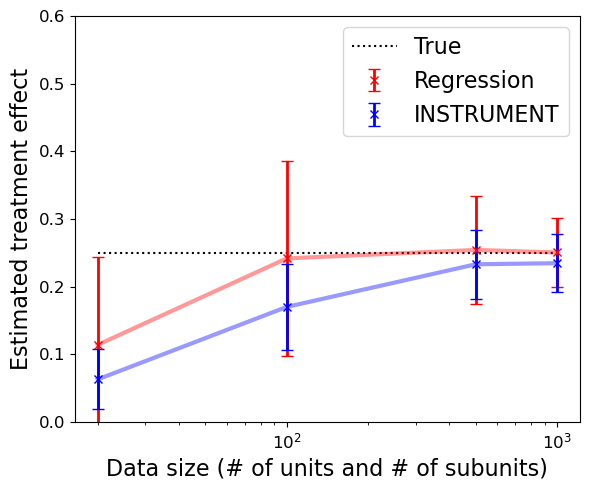

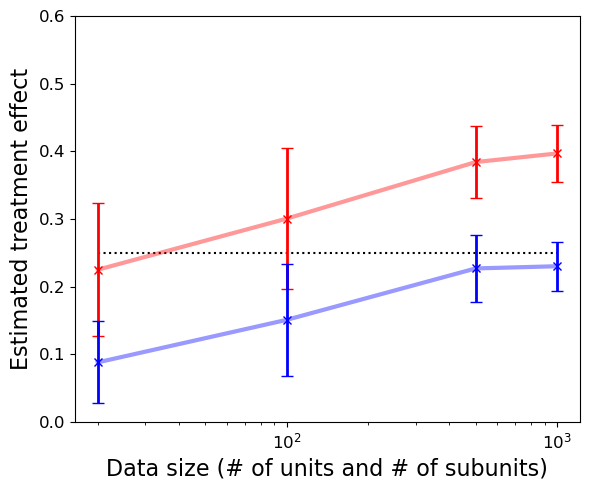

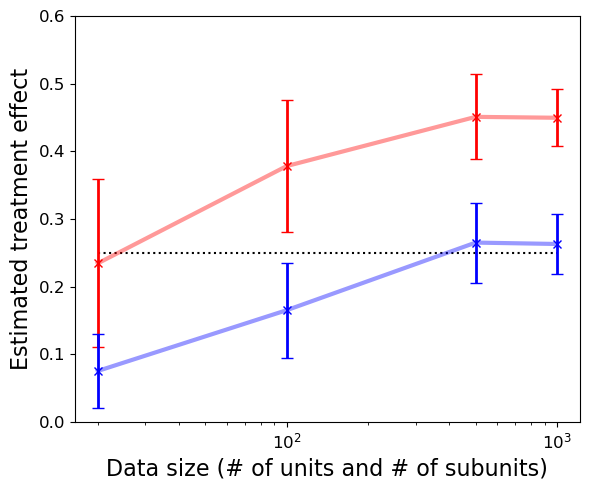

In [8]:
reps = 20
c_strength_low = 0.
nsamps_low, true_effect_low, estimated_effect_low, regress_effect_low = (
    estimator_convergence(c_strength_low, reps))
make_plot(c_strength_low, nsamps_low, true_effect_low, estimated_effect_low, regress_effect_low, 
          save=True, ylim=[0, 0.6], legend=True)
c_strength_med = 0.2
nsamps_med, true_effect_med, estimated_effect_med, regress_effect_med = (
    estimator_convergence(c_strength_med, reps))
make_plot(c_strength_med, nsamps_med, true_effect_med, estimated_effect_med, regress_effect_med, 
          save=True, ylim=[0, 0.6], legend=False)
c_strength_high = 0.5
nsamps_high, true_effect_high, estimated_effect_high, regress_effect_high = (
    estimator_convergence(c_strength_high, reps))
make_plot(c_strength_high, nsamps_high, true_effect_high, estimated_effect_high, regress_effect_high, 
          save=True, ylim=[0, 0.6], legend=False)